# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__


In [1]:
import gym
import gym.wrappers
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, HTML
from joblib import Parallel, delayed

from sklearn.neural_network import MLPClassifier

import os
from time import time

import warnings
warnings.filterwarnings("ignore") 

state vector dim = 4
n_actions = 2


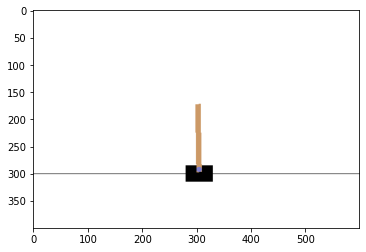

In [2]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [3]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__

You may also use your favorite neural framework, if it doesn't make it too difficult. The idea is the main thing.

In [4]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

Как оказалось argmax плохо решает поставленную задачу, лучше использовать random.choice. С аргмаксом мне даже не удалось решить задачу, за которую уже дают баллы. 

In [5]:
def generate_session(agent, t_max=1000, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0, :] #<YOUR CODE>

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        if test:
            # on the test use the best (the most likely) actions at test
            # experiment, will it work on the train and vice versa?
            # Как я понял из следующего задания аргмакс плохо решает задачу, лучше random choice
            a = np.random.choice(probs.shape[0], p=probs)
#             a = np.argmax(probs) #<YOUR CODE>
            # ^-- hint: try np.argmax
        else:
            # sample proportionally to the probabilities,
            # don't just take the most likely action at train
            a = np.random.choice(n_actions) #<YOUR CODE>
            # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
            
    return states, actions, total_reward

In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.02404523 -0.02208781  0.03787742  0.0275692 ]
 [-0.02448699  0.17247106  0.03842881 -0.25292647]
 [-0.02103757 -0.02317795  0.03337028  0.05162565]
 [-0.02150112 -0.21876211  0.03440279  0.3546476 ]
 [-0.02587637 -0.02414578  0.04149574  0.07300827]]
actions: [1, 0, 0, 1, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

Let's see that it differs from tabular `select_elites`. Our neural network now is trained with one object and it takes an input of `(1, n_states)`. So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.

In [7]:
def flatten(lst):
    out = []
    for sublist in list(lst):
        out.extend(sublist)
    return np.array(out)

def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
        
    idx = [rewards_batch >= np.percentile(rewards_batch, percentile)]
    elite_states = states_batch[idx]
    elite_actions = actions_batch[idx]
    elite_states = flatten(elite_states)
    elite_actions = flatten(elite_actions)
    
    # Let's see that it differs from tabular `select_elites`.
    # Our neural network now is trained with one object and it takes an input of `(1, n_states)`.
    # So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.
    
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

Тут я немного улучшил функцию, теперь она выводит распределения на elite_actions

In [8]:
def show_progress(rewards_batch, log, percentile, elite_actions, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 3, 3)
    plt.hist(elite_actions, label='Probs elite actions')
    plt.legend()
    plt.grid()
    
    clear_output(True)
    plt.show()

Первую сессию я инициализурую рандомом, а потом уже обучаю на этих данных агента 

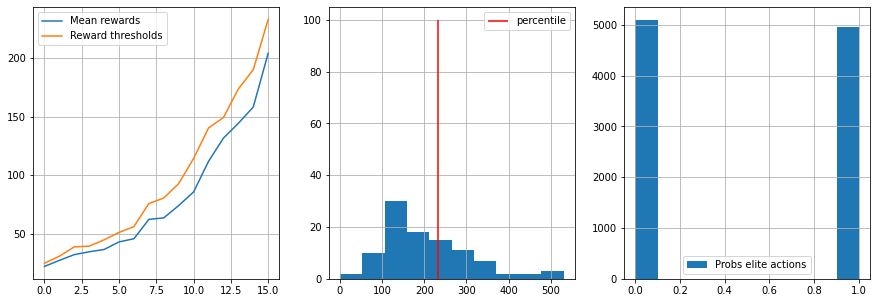

You Win! You may stop training now via KeyboardInterrupt.


In [9]:
# https://github.com/Scitator/rl-course-experiments/blob/master/CEM/cem_gym.py
np.random.seed(42)
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    random_state = 42
)

agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))


n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    if i == 0 :
        sessions = [generate_session(agent, test=False, t_max=10000) for _ in range(n_sessions)]
    else:
        sessions = [generate_session(agent, test=True, t_max=10000) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    
    if i ==0:
        agent.fit(elite_states, elite_actions)
    else: 
        agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, elite_actions, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Results

In [10]:
# record sessions
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(agent, test=True) for _ in range(100)]
env.close()

In [11]:
# show video
video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

# Homework

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks (up to 1 point each)

* __2.1__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8) or multiprocessing
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

### В своей реализации я буду использовать LunarLander-v2.

state vector dim = 8
n_actions = 4


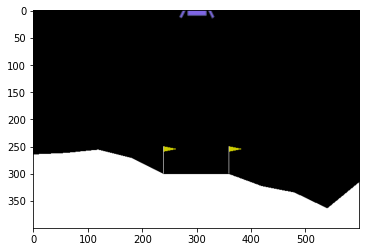

In [12]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("LunarLander-v2").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [13]:
env.observation_space, env.action_space

(Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32),
 Discrete(4))

# 1. Замерим время при обычном решении задания

Тут почти без изменений по сравнению с частью, где баллы не выдают. А при решении задания я пользовался этими источниками:
- https://medium.com/coinmonks/landing-a-rocket-with-simple-reinforcement-learning-3a0265f8b58c
- https://github.com/KohlerHECTOR/LunarLander-v2

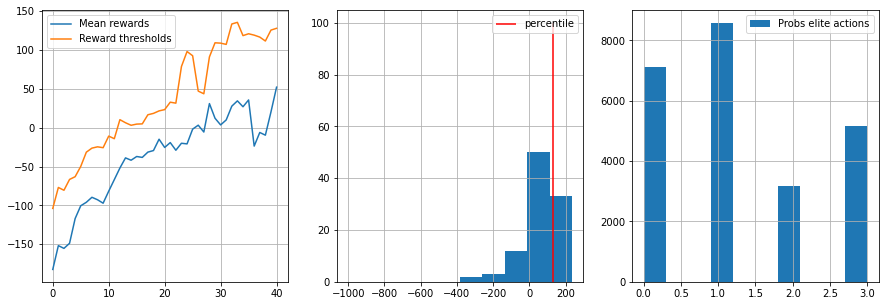

Ура, задание сделано
Общее время - 1281.6253049373627


In [14]:
start = time()

np.random.seed(42)
agent = MLPClassifier(
                        hidden_layer_sizes=(200),
                        activation='relu',
                        random_state = 42,
                        learning_rate_init = 0.01
                    )

agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))


n_sessions = 100
percentile = 80
log = []

for i in range(500):
    # generate new sessions
    if i == 0 :
        sessions = [generate_session(agent, test=False, t_max=1500) for _ in range(n_sessions)]
    else:
        sessions = [generate_session(agent, test=True, t_max=1500) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    
    if i ==0:
        agent.fit(elite_states, elite_actions)
    else: 
        agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, elite_actions, reward_range=[-1000, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 50:
        print('Ура, задание сделано')
        print('Общее время - {}'.format(time() - start))
        break

# 2. Реализуем параллельность в создании сессий и штраф за медленное решение. Это ускорит обучение в более чем в 2 раза

Теперь функция также выдает батч со штрафом, если его прибавить к батчу с вознаграждением, то мы получим оригинальный батч с вознаграждением

In [15]:
def generate_session(agent, t_max=1000, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        probs = agent.predict_proba([s])[0, :] #<YOUR CODE>

        if test:
            a = np.random.choice(probs.shape[0], p=probs)
        else:
            a = np.random.choice(n_actions) 

        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    total_reward -= t*0.1
            
    return states, actions, total_reward, t*0.1

def generate_parallel_sessions(agent, n, t_max, test, n_jobs=-1):
    return Parallel(n_jobs)(n * [delayed(generate_session)(agent, t_max, test)])

В этой части я классификатор не трогал, ускорение реализовано только через награду и параллельность сессий. 

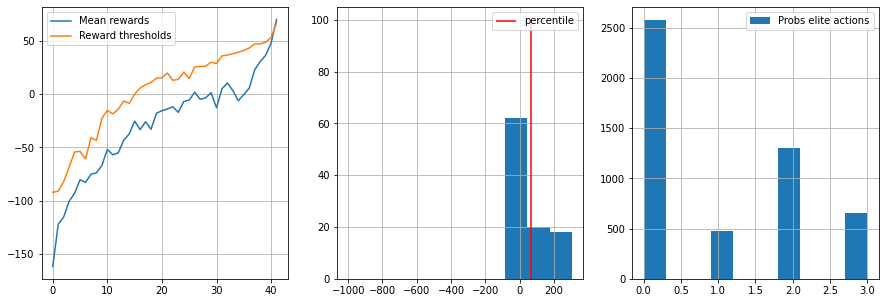

Ура, задание сделано
Общее время - 64.39668321609497


In [16]:
start = time()
n_sessions = 100
percentile = 80
log = []

for i in range(500):
    
    # generate new sessions
    if i == 0 :
        agent = MLPClassifier(hidden_layer_sizes=(1))
        agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
        sessions = generate_parallel_sessions(agent, n_sessions, test=False, t_max=1500)
        agent = MLPClassifier(
                                hidden_layer_sizes=(200),
                                activation='relu',
                                random_state = 42,
                                learning_rate_init = 0.01
                            )
    else:
        sessions = generate_parallel_sessions(agent, n_sessions, test=True, t_max=1500) 
    
    states_batch, actions_batch, rewards_batch, t_batch = map(np.array, zip(*sessions))
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    if i ==0:
        agent.fit(elite_states, elite_actions)
    else: 
        agent.partial_fit(elite_states, elite_actions)
    
    
    show_progress(rewards_batch+t_batch, log, percentile, elite_actions, reward_range=[-1000, 
                                                                                       np.max(rewards_batch+t_batch)])
    
    if np.mean(rewards_batch+t_batch) > 50:
        print('Ура, задание сделано')
        print('Общее время - {}'.format(time() - start))
        break

Все, конечно, очень сильно зависит от перезапуска, но в моем случае в среднем ускоренный способ работает в 5-7 раз быстрее обычного. Удивительно, что ускорение на разных устройствах совсем разное, на ноутбуке, оно не так заметно, как на стационарном ПК. Видимо это связано с особенностями библиотек `gym` и `joblib` на разных ОС. При этом процессоры сопостовимы по производительности. 

# Визуализация результатов

In [17]:
# record sessions
env = gym.wrappers.Monitor(gym.make("LunarLander-v2"),
                           directory="videos", force=True)
sessions = [generate_session(agent, test=True, t_max=5000) for _ in range(100)]
env.close()

In [18]:
# show video
video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

### Bonus tasks (up to 0.5 points)

* __2.3 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v0"](https://github.com/openai/gym/wiki/Pendulum-v0).
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Solve [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2). Slightly less points for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.
  * __Please list what you did in anytask submission form__

### Попробуем решить сначала Pendulum-v0

state vector dim = 3


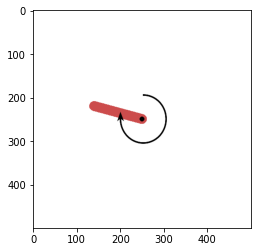

In [19]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("Pendulum-v1").env

env.reset()
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)

env.close()

In [20]:
env.observation_space, env.action_space

(Box([-1. -1. -8.], [1. 1. 8.], (3,), float32),
 Box([-2.], [2.], (1,), float32))

### Будем решать через классификатор, через регрессор у меня не получилось(

Ох как я только не старался с регрессором, то у меня ничего не получалось. И шум я добавлял и выход регрессора тоже на бины разбивал, но что-то вообще никак не получалось. Просто регрессор выдавал что-то похожее на нормальное распределение около нуля. 

In [21]:
def create_action_bins(z):
    actionbins = np.linspace(-2.0, 2.0, z)
    return actionbins

def find_actionbin(action, actionbins):
    idx = (np.abs(actionbins - action)).argmin(axis=1)
    return idx

def generate_session(agent, t_max=1000, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0
    actionbins = np.linspace(-2.0, 2.0, 3)

    s = env.reset()

    for t in range(t_max):
        probs = agent.predict_proba([s])[0, :]

        if test:
            a = np.random.choice(probs.shape[0], p=probs)
            a = [actionbins[a]]
        else:
            a = [np.random.choice(actionbins)] 


        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward, 0

def generate_parallel_sessions(agent, n, t_max, test, n_jobs=-1):
    return Parallel(n_jobs)(n * [delayed(generate_session)(agent, t_max, test)])

Процесс обучения

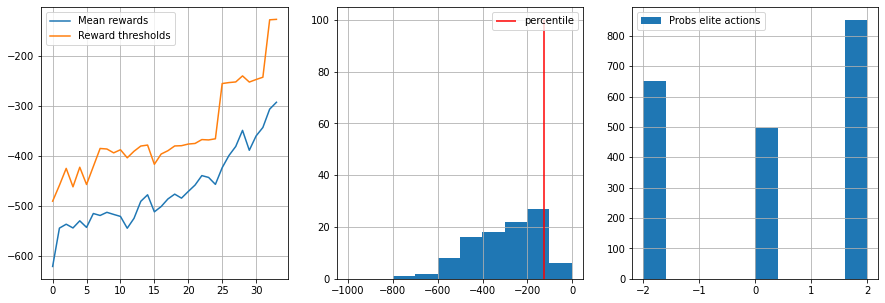

Думаю, что хватит
Общее время - 115.1415855884552


In [22]:
start = time()
n_sessions = 100
percentile = 80
log = []
actionbins = np.linspace(-2.0, 2.0, 3)

for i in range(500):
    
    # generate new sessions
    if i == 0 :
        agent = MLPClassifier(hidden_layer_sizes=(1))
        agent.partial_fit([env.reset()] * 1, range(1), range(1))
        sessions = generate_parallel_sessions(agent, n_sessions, test=False, t_max=100, n_jobs=1)
        agent = MLPClassifier(
                                hidden_layer_sizes=(50, 50),
                                activation='relu',
                                random_state = 42,
                                learning_rate_init = 0.01
                            )
    else:
        sessions = generate_parallel_sessions(agent, n_sessions, test=True, t_max=100, n_jobs=1) 
    
    states_batch, actions_batch, rewards_batch, t_batch = map(np.array, zip(*sessions))
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    
    elite_actions_binary = find_actionbin(elite_actions, actionbins)

    if i ==0:
        agent.fit(elite_states, elite_actions_binary)
    else: 
        agent.partial_fit(elite_states, elite_actions_binary)
    
    
    show_progress(rewards_batch+t_batch, log, percentile, elite_actions, reward_range=[-1000, 
                                                                                       np.max(rewards_batch+t_batch)])
    
    if np.mean(rewards_batch+t_batch) > -300:
        print('Думаю, что хватит')
        print('Общее время - {}'.format(time() - start))
        break

# Теперь попробуем решить LunarLanderContinuous-v2

state vector dim = 8


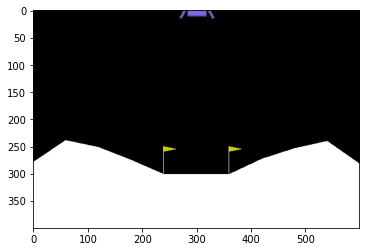

In [23]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("LunarLanderContinuous-v2").env

env.reset()
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)

env.close()

Максимально костыльный способ решения задачи. Но как говорится умей крутиться в колесе. 

In [24]:
def action_lander(class_):
    if class_ == 0:
        a = [-1, -1]
    elif class_ == 1:
        a = [-1, 1]
    elif class_ == 2:
        a = [1, 1]
    elif class_ == 3:
        a = [-1, 0]
    else:
        a = [1, -1]
    return a

def reverse_actions(a):
    if a == [-1, -1]:
        class_ = 0
    elif a == [-1, 1]:
        class_ = 1
    elif a == [1, 1]:
        class_ = 2
    elif a == [-1, 0]:
        class_ = 3
    else:
        class_ = 4
    return class_

Тут я тоже использую штраф за долгое решение задачи 

In [25]:
def generate_session(agent, t_max=1000, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        probs = agent.predict_proba([s])[0, :] 
        if test:
            a = np.random.choice(probs.shape[0], p=probs)
            a = action_lander(a)
        else:
            a = np.random.choice(range(5)) 
            a = action_lander(a)

        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    total_reward -= t*0.1
            
    return states, actions, total_reward, t*0.1

def generate_parallel_sessions(agent, n, t_max, test, n_jobs=-1):
    return Parallel(n_jobs)(n * [delayed(generate_session)(agent, t_max, test)])

Процесс обучения

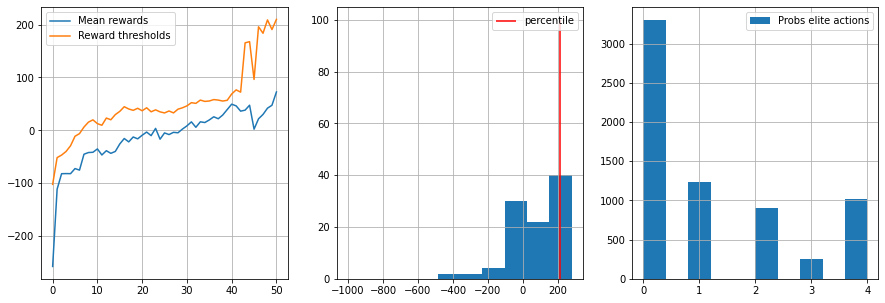

Ура задание сделано
Общее время - 229.83914589881897


In [26]:
start = time()
n_sessions = 100
percentile = 80
log = []

for i in range(500):
    
    # generate new sessions
    if i == 0 :
        agent = MLPClassifier(hidden_layer_sizes=(1))
        agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))
        sessions = generate_parallel_sessions(agent, n_sessions, test=False, t_max=1500)
        agent = MLPClassifier(
                                hidden_layer_sizes=(200),
                                activation='relu',
                                random_state = 42,
                                learning_rate_init = 0.01
                            )
    else:
        sessions = generate_parallel_sessions(agent, n_sessions, test=True, t_max=1500) 
    
    states_batch, actions_batch, rewards_batch, t_batch = map(np.array, zip(*sessions))
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    
    elite_actions_binary = np.array([reverse_actions(list(a)) for a in elite_actions])
    
    
    if i ==0:
        agent.fit(elite_states, elite_actions_binary)
    else: 
        agent.partial_fit(elite_states, elite_actions_binary)
    
    
    show_progress(rewards_batch+t_batch, log, percentile, elite_actions_binary, reward_range=[-1000, 
                                                                                       np.max(rewards_batch+t_batch)])
    
    if np.mean(rewards_batch+t_batch) > 50:
        print('Ура задание сделано')
        print('Общее время - {}'.format(time() - start))
        break

Да, это не правильно решать таким костыльным образом задание и по хорошему надо было делать через регрессор, но я пробовал и у меня не получилось( Но с другой стороны у нас было всего одного занятие и неделя на ДЗ, поэтому считаю приемлемо для первого раза такое решение. Все таки не другим же подходом решал)

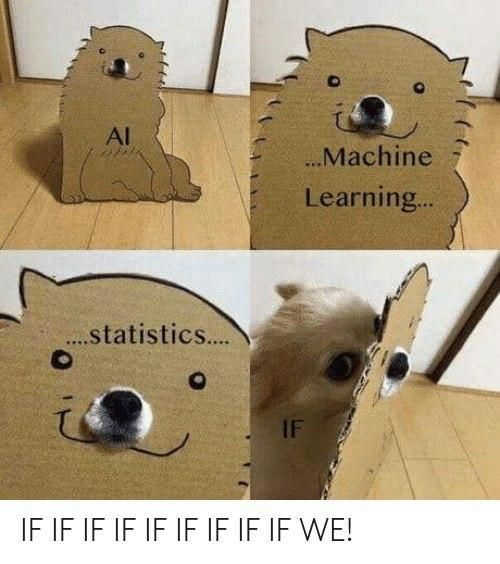